In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import sys

sys.path.append('../src')
from nsc_model import nsc_model
from Constants import Constants
from star_disk import orbit,disk,disk_Q,star_disk

from astropy.io import ascii
from astropy.table import Table
from glob import glob
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.interpolate import griddata

c=Constants()

%matplotlib inline

# set some global options
plt.rcParams['figure.figsize'] = (6,5)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.borderpad'] = 0.2
plt.rcParams['legend.labelspacing'] = 0.2
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 16

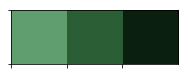

In [63]:
import seaborn as sns

myc = sns.cubehelix_palette(3,start=2,rot=0.,gamma=1.25,light=0.6)
sns.palplot( myc )

Mdot_Edd =  0.022182035411211505 (msun/yr) Mdot_disk = 0.022182035411211505 (msun/yr)
Mdot_Edd =  0.22182035411211506 (msun/yr) Mdot_disk = 0.22182035411211506 (msun/yr)
Mdot_Edd =  2.2182035411211505 (msun/yr) Mdot_disk = 2.2182035411211505 (msun/yr)


//anaconda/envs/python3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
//anaconda/envs/python3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
//anaconda/envs/python3/lib/python3.7/site-packages/matplotl

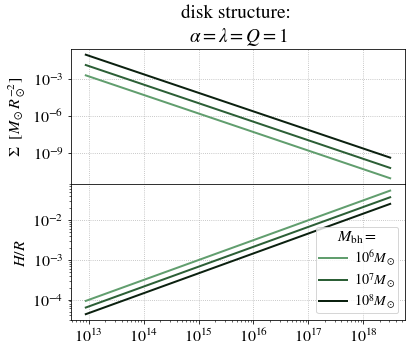

In [79]:
labeltext=[r"$10^6M_\odot$",r"$10^7M_\odot$",r"$10^8M_\odot$"]

for i,Mbh in enumerate([1e6,1e7,1e8]):

    d = disk_Q(Mbh*c.msun,c.msun,c.rsun,lambda_disk=1,alpha_disk=1,Q_disk=1)

    r = np.logspace(np.log10(6*c.G*1.e7*c.msun/c.c**2),np.log10(c.pc),100)

    plt.subplot(211)
    plt.plot(r,d.sigma(r)/(c.msun/c.rsun**2),color=myc[i],lw=2)
    plt.loglog()
    plt.xticks(visible=False)
    plt.grid(ls=':')
    plt.ylabel("$\Sigma \ \ [M_\odot  R_\odot^{-2}]$")

    plt.subplot(212)
    plt.plot(r,d.h(r),color=myc[i],lw=2,label=labeltext[i])
    plt.loglog()
    plt.grid(ls=':')
    plt.ylabel("$H/R$")
    plt.legend(loc='lower right',title=r'$M_{\rm bh} = $',frameon=True)
    


plt.subplots_adjust(hspace=0)
plt.subplot(211)
plt.title("disk structure: \n"+ r"$\alpha=\lambda=Q=1$")

plt.savefig("../../disk_structure.pdf",bbox_inches='tight')

In [2]:
def generate_random_elements(nsample):
    xx = np.random.normal(size=nsample)
    yy = np.random.normal(size=nsample)
    zz = np.random.normal(size=nsample)
    direction = np.array([xx,yy,zz]).T

    # randomly oriented h-vector
    h_norm =[]
    for i in range(len(direction)):
        h_norm.append(direction[i]/np.linalg.norm(direction,axis=1)[i])

    h_norm=np.array(h_norm)

    #fig = plt.figure(figsize=(8,5))
    #ax=fig.add_subplot(111, projection='3d')
    #ax.scatter(h_norm[:,0],h_norm[:,1],h_norm[:,2],alpha=0.1)


    # compute orbital elements
    I_list = np.arccos(h_norm[:,2]/1.) 
    OMEGA_list = np.arctan2(h_norm[:,0],-h_norm[:,1])
    omega_list = np.random.uniform(low=-np.pi,high=np.pi,size=len(I_list))

    # position of apoapse
    #p_apo = []
    #for i in range(len(direction)):
    #    p_apo.append( orb.elements_to_POS_VEL((1,0.9,OMEGA_list[i],omega_list[i],I_list[i],np.pi))[0] )
    #p_apo = np.array(p_apo)
    # plot apoapse positions to confirm randomly oriented
    #fig = plt.figure(figsize=(8,5))
    #ax=fig.add_subplot(111, projection='3d')
    #ax.scatter(p_apo[:,0],p_apo[:,1],p_apo[:,2],alpha=0.1)
    
    return OMEGA_list,omega_list,I_list



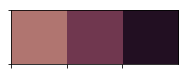

In [3]:
import seaborn as sns

myc = sns.cubehelix_palette(3,start=0.25,rot=0.4,gamma=1.25,light=0.6)
sns.palplot( myc )

In [11]:
nsample = 10000

s=star_disk(Mbh=1.e7*c.msun,
            ms=c.msun,
            rs=c.rsun,
            lambda_disk=1,
            alpha_disk =1,
            Q_disk=1,
            gamma=1.5)    

beta = 1./30.
rt = (s.Mbh/s.ms)**(1./3.)*s.rs
a = 0.1*s.n.r_h     # 0<a<inf
e = 1.-(1./beta)*rt/a         # 0<e<1

OMEGA_list,omega_list,I_list = generate_random_elements(nsample)

# FILTER THESE TO ONLY INCLUDE THOSE *OUT* OF THE DISK PLANE

data = []

for i in range(nsample):
    if i%1000==0: 
        print (i)
    my_ele = (a,e,OMEGA_list[i],omega_list[i],I_list[i])
    
    c1_ele = s.disk_cross(my_ele,direction="in")
    
    if(c1_ele[0]*(1.-c1_ele[1])>rt): # flag tidal disruptions 
        c2_ele = s.disk_cross(c1_ele,direction="out")
    else:
        c2_ele = (99,99,99,99,99)
        
    dE,E,dh,h = s.orb_delta_EJ(my_ele)
    data.append([my_ele[0],my_ele[1],my_ele[2],my_ele[3],my_ele[4],my_ele[0]*(1.-my_ele[1])/rt,
                 c1_ele[0],c1_ele[1],c1_ele[2],c1_ele[3],c1_ele[4],c1_ele[0]*(1.-c1_ele[1])/rt,
                 c2_ele[0],c2_ele[1],c2_ele[2],c2_ele[3],c2_ele[4],c2_ele[0]*(1.-c2_ele[1])/rt])

dtab = Table(np.array(data),names=['a0','e0','OM0','om0','I0','rp/rt0','ap','ep','OMp','omp','Ip','rp/rtp','af','ef','OMf','omf','If','rp/rtf'])

Mdot_Edd =  0.22182035411211506 (msun/yr) Mdot_disk = 0.22182035411211506 (msun/yr)
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [17]:
Table.write(dtab,format='ascii',filename='stardisk_random_orient_beta1o30.dat')

# Read the table, plot

In [84]:
np.tan(np.pi-1.e-2)

-0.010000333346667115

('Mdot_Edd = ', 0.22182035411211506, '(msun/yr) Mdot_disk =', 0.22182035411211506, '(msun/yr)')
9993


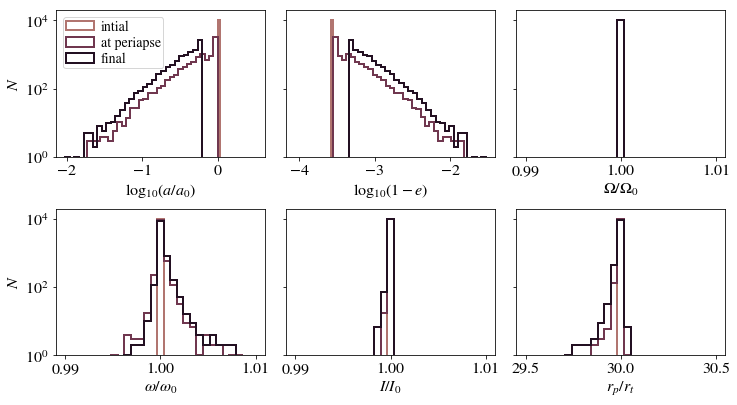

In [10]:
dtab = Table.read('stardisk_random_orient_beta1o30.dat',format='ascii')

nsample = len(dtab)

s=star_disk(Mbh=1.e7*c.msun,
            ms=c.msun,
            rs=c.rsun,
            lambda_disk=1,
            alpha_disk =1,
            Q_disk=1,
            gamma=1.5)  

beta = 1./30.
rt = (s.Mbh/s.ms)**(1./3.)*s.rs
a = 0.1*s.n.r_h     # 0<a<inf
e = 1.-(1./beta)*rt/a         # 0<e<1

# Select only things that are out of the disk plane
sel = (np.abs(np.tan(dtab['I0'])) >  s.d.h(a*(1+e)) )
print (len(dtab[sel]))

plt.figure(figsize=(12,10))

plt.subplot(331)
plt.hist(np.log10(dtab[sel]['a0']/dtab[sel]['a0']),
         density=False,bins=30,histtype='step',lw=2,label='intial',color=myc[0])
plt.hist(np.log10(dtab[sel]['ap']/dtab[sel]['a0']),
         density=False,bins=30,histtype='step',lw=2,label='at periapse',color=myc[1])
plt.hist(np.log10(dtab[sel]['af']/dtab[sel]['a0']),
         density=False,bins=30,histtype='step',lw=2,label='final',color=myc[2])
plt.xlabel(r'$\log_{10}\left(a/a_0\right)$')
plt.ylabel('$N$')
plt.yscale('log')
plt.ylim(1,2*nsample)
plt.legend(loc='upper left',frameon=True)


plt.subplot(332)
plt.hist(np.log10(1-dtab[sel]['e0']),
         density=False,bins=30,histtype='step',lw=2,label='initial',color=myc[0])
plt.hist(np.log10(1-dtab[sel]['ep']),
         density=False,bins=30,histtype='step',lw=2,label='at periapse',color=myc[1])
plt.hist(np.log10(1-dtab[sel]['ef']),
         density=False,bins=30,histtype='step',lw=2,label='final',color=myc[2])
plt.xlabel(r'$\log_{10}\left(1-e\right)$')
#plt.ylabel('PDF')
plt.yticks(visible=False)
plt.yscale('log')
plt.ylim(1,2*nsample)
#plt.legend(loc='upper right',frameon=True)


plt.subplot(333)
plt.hist(dtab[sel]['OM0']/dtab[sel]['OM0'],
         density=False,bins=np.linspace(0.99,1.01,30),histtype='step',lw=2,label='intial',color=myc[0])
plt.hist(dtab[sel]['OMp']/dtab[sel]['OM0'],
         density=False,bins=np.linspace(0.99,1.01,30),histtype='step',lw=2,label='at periapse',color=myc[1])
plt.hist(dtab[sel]['OMf']/dtab[sel]['OM0'],
         density=False,bins=np.linspace(0.99,1.01,30),histtype='step',lw=2,label='final',color=myc[2])
plt.xlabel(r'$\Omega/\Omega_0$')
#plt.ylabel('PDF')
plt.yticks(visible=False)
plt.yscale('log')
plt.ylim(1,2*nsample)
#plt.legend(loc='upper left',frameon=True)


plt.subplot(334)
plt.hist(dtab[sel]['om0']/dtab[sel]['om0'],
         density=False,bins=np.linspace(0.99,1.01,30),histtype='step',lw=2,label='intial',color=myc[0])
plt.hist(dtab[sel]['omp']/dtab[sel]['om0'],
         density=False,bins=np.linspace(0.99,1.01,30),histtype='step',lw=2,label='at periapse',color=myc[1])
plt.hist(dtab[sel]['omf']/dtab[sel]['om0'],
         density=False,bins=np.linspace(0.99,1.01,30),histtype='step',lw=2,label='final',color=myc[2])
plt.xlabel(r'$\omega/\omega_0$')
plt.ylabel('$N$')
plt.yscale('log')
plt.ylim(1,2*nsample)
#plt.legend(loc='upper left',frameon=True)


plt.subplot(335)
plt.hist(dtab[sel]['I0']/dtab[sel]['I0'],
         density=False,bins=np.linspace(0.99,1.01,30),histtype='step',lw=2,label='intial',color=myc[0])
plt.hist(dtab[sel]['Ip']/dtab[sel]['I0'],
         density=False,bins=np.linspace(0.99,1.01,30),histtype='step',lw=2,label='at periapse',color=myc[1])
plt.hist(dtab[sel]['If']/dtab[sel]['I0'],
         density=False,bins=np.linspace(0.99,1.01,30),histtype='step',lw=2,label='final',color=myc[2])
plt.xlabel(r'$I/I_0$')
#plt.ylabel('PDF')
plt.yticks(visible=False)
plt.yscale('log')
plt.ylim(1,2*nsample)


plt.subplot(336)
plt.hist(dtab[sel]['rp/rt0'],
         density=False,bins=np.linspace(29.5,30.5,30),histtype='step',lw=2,label='initial',color=myc[0])
plt.hist(dtab[sel]['rp/rtp'],
         density=False,bins=np.linspace(29.5,30.5,30),histtype='step',lw=2,label='at periapse',color=myc[1])
plt.hist(dtab[sel]['rp/rtf'],
         density=False,bins=np.linspace(29.5,30.5,30),histtype='step',lw=2,label='final',color=myc[2])
plt.xlabel(r'$r_p/r_t$')
#plt.ylabel('PDF')
plt.yticks(visible=False)
plt.yscale('log')
plt.ylim(1,2*nsample)

plt.subplots_adjust(hspace=0.35,wspace=0.1)
plt.savefig("single_orb_elements_distribution.pdf",bbox_inches='tight')

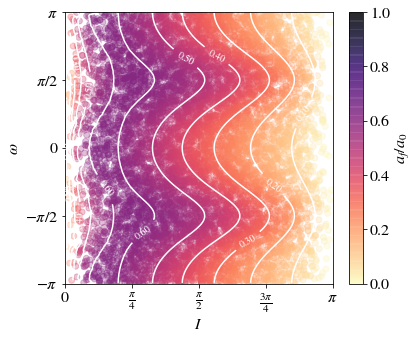

In [13]:
plt.axvline(np.pi/2,color='grey',ls='--',zorder=0)
im=plt.scatter(dtab['I0'],dtab['om0'],c=dtab['af']/dtab['a0'],alpha=0.3,cmap='magma_r',vmin=0,vmax=1,rasterized=True)

points = np.array([dtab['I0'],dtab['om0']]).T
values = dtab['af']/dtab['a0']

xx,yy = np.meshgrid(np.linspace(0,np.pi,300),np.linspace(-np.pi,np.pi,300))

grid_z0 = griddata(points,values,(xx,yy),method="nearest")
grid_z1 = griddata(points,values,(xx,yy),method="linear")
CS =plt.contour(xx,yy,grid_z1,colors='w',linestyles='-',levels=np.linspace(0,1,11))
plt.clabel(CS, inline=1, fontsize=10,fmt='%1.2f')


plt.xlabel('$I$')
plt.xticks([0,np.pi/4,np.pi/2,3*np.pi/4,np.pi],[0,r"$\frac{\pi}{4}$",r"$\frac{\pi}{2}$",r"$\frac{3\pi}{4}$",r"$\pi$"])
plt.ylabel(r'$\omega$')
plt.yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],["$-\pi$","$-\pi/2$",0,"$\pi/2$","$\pi$"])
plt.ylim(-np.pi-0.5,np.pi+0.5)

cb=plt.colorbar(im,label=r'$a_f/a_0$')
cb.solids.set_edgecolor("face")
plt.xlim(0,np.pi)
plt.ylim(-np.pi,np.pi)
plt.savefig("single_orb_elements_Iomega.pdf",bbox_inches='tight')

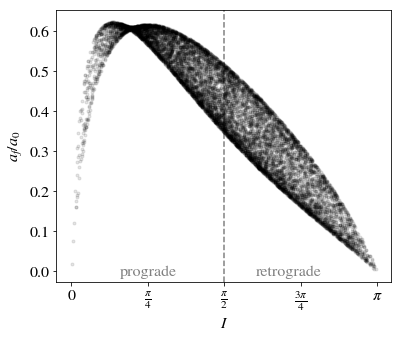

In [14]:
plt.axvline(np.pi/2,color='grey',ls='--',zorder=0)
#plt.scatter(dtab['I0'],dtab['af']/dtab['a0'],c=dtab['om0'],alpha=0.3,cmap='PiYG',vmin=-np.pi,vmax=np.pi)
plt.plot(dtab['I0'],dtab['af']/dtab['a0'],'k.',alpha=0.1,rasterized=True)
plt.xlabel('$I$')
plt.xticks([0,np.pi/4,np.pi/2,3*np.pi/4,np.pi],[0,r"$\frac{\pi}{4}$",r"$\frac{\pi}{2}$",r"$\frac{3\pi}{4}$",r"$\pi$"])
plt.ylabel('$a_f/a_0$')
#cb=plt.colorbar(label=r'$\omega$')
#cb.set_ticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
#cb.set_ticklabels(["$-\pi$","$-\pi/2$",0,"$\pi/2$","$\pi$"])
#cb.solids.set_edgecolor("face")
plt.annotate("prograde",(0.5,-0.01),color='grey')
plt.annotate("retrograde",(1.9,-0.01),color='grey')
plt.savefig("single_orb_elements_I.pdf",bbox_inches='tight')

# Comparison to two-body scattering

In [15]:
def deltaE_deltaJ_dist(s,a,e,nsample=100):
    OMEGA_list,omega_list,I_list = generate_random_elements(nsample)
    data = []
    for i in range(nsample):
        my_ele = (a,e,OMEGA_list[i],omega_list[i],I_list[i])
        dE,E,dh,h = s.orb_delta_EJ(my_ele)
        data.append([E,dE,h,dh])
    return Table(np.array(data),names=['E','dE','h','dh'] )

In [16]:
s=star_disk(Mbh=1.e7*c.msun,
            ms=c.msun,
            rs=c.rsun,
            lambda_disk=1,
            alpha_disk =1,
            Q_disk=1,
            gamma=1.5)  

na=30
e = 0.9
a_list = np.logspace(-2.5,1,na)*s.n.r_h
data = []
for k in range(na):
    a = a_list[k]
    dtab = deltaE_deltaJ_dist(s,a,e,nsample=1000)
    dE_o_E_m  =  np.percentile(abs(dtab['dE']/dtab['E']),50)
    dE_o_E_5  =  np.percentile(abs(dtab['dE']/dtab['E']),5)
    dE_o_E_95 =  np.percentile(abs(dtab['dE']/dtab['E']),95)
    
    dh_o_h_m  =  np.percentile(abs(dtab['dh']/dtab['h']),50)
    dh_o_h_5  =  np.percentile(abs(dtab['dh']/dtab['h']),5)
    dh_o_h_95 =  np.percentile(abs(dtab['dh']/dtab['h']),95)
    
    data.append([a,dE_o_E_m,dE_o_E_5,dE_o_E_95,dh_o_h_m,dh_o_h_5,dh_o_h_95])
    
dtab9 = Table(np.array(data),names=["a","dE_o_E_m","dE_o_E_5","dE_o_E_95","dh_o_h_m","dh_o_h_5","dh_o_h_95"]) 


na=30
e = 0.99
a_list = np.logspace(-2.5,1,na)*s.n.r_h
data = []
for k in range(na):
    a = a_list[k]
    dtab = deltaE_deltaJ_dist(s,a,e,nsample=1000)
    dE_o_E_m  =  np.percentile(abs(dtab['dE']/dtab['E']),50)
    dE_o_E_5  =  np.percentile(abs(dtab['dE']/dtab['E']),5)
    dE_o_E_95 =  np.percentile(abs(dtab['dE']/dtab['E']),95)
    
    dh_o_h_m  =  np.percentile(abs(dtab['dh']/dtab['h']),50)
    dh_o_h_5  =  np.percentile(abs(dtab['dh']/dtab['h']),5)
    dh_o_h_95 =  np.percentile(abs(dtab['dh']/dtab['h']),95)
    
    data.append([a,dE_o_E_m,dE_o_E_5,dE_o_E_95,dh_o_h_m,dh_o_h_5,dh_o_h_95])
    
dtab99 = Table(np.array(data),names=["a","dE_o_E_m","dE_o_E_5","dE_o_E_95","dh_o_h_m","dh_o_h_5","dh_o_h_95"]) 

na=30
e = 0.999
a_list = np.logspace(-2.5,1,na)*s.n.r_h
data = []
for k in range(na):
    a = a_list[k]
    dtab = deltaE_deltaJ_dist(s,a,e,nsample=1000)
    dE_o_E_m  =  np.percentile(abs(dtab['dE']/dtab['E']),50)
    dE_o_E_5  =  np.percentile(abs(dtab['dE']/dtab['E']),5)
    dE_o_E_95 =  np.percentile(abs(dtab['dE']/dtab['E']),95)
    
    dh_o_h_m  =  np.percentile(abs(dtab['dh']/dtab['h']),50)
    dh_o_h_5  =  np.percentile(abs(dtab['dh']/dtab['h']),5)
    dh_o_h_95 =  np.percentile(abs(dtab['dh']/dtab['h']),95)
    
    data.append([a,dE_o_E_m,dE_o_E_5,dE_o_E_95,dh_o_h_m,dh_o_h_5,dh_o_h_95])
    
dtab999 = Table(np.array(data),names=["a","dE_o_E_m","dE_o_E_5","dE_o_E_95","dh_o_h_m","dh_o_h_5","dh_o_h_95"]) 

('Mdot_Edd = ', 0.22182035411211506, '(msun/yr) Mdot_disk =', 0.22182035411211506, '(msun/yr)')


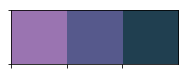

In [17]:
myc = sns.cubehelix_palette(3,start=2,rot=0.7,gamma=1.25,light=0.6,dark=0.3,reverse=True)
sns.palplot( np.flipud(myc) )

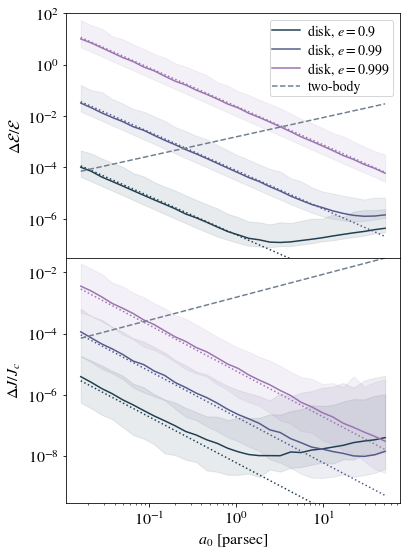

In [18]:
tbc='SlateGray'
plt.figure(figsize=(6,9))

# ENERGY
plt.subplot(211)

## e=0.9
plt.plot(dtab9['a']/c.pc,
         dtab9['dE_o_E_m'],
         label='disk, $e=0.9$',color=myc[0])
plt.fill_between(dtab9['a']/c.pc,
                 dtab9['dE_o_E_5'],
                 dtab9['dE_o_E_95'],
                 alpha=0.1,color=myc[0])

ecc = 0.9
dm_o_ms = (s.d.sigma(dtab9['a']*(1-ecc))*np.pi*s.rs**2 / s.ms)
DeltaEoE_OoM = 4* dm_o_ms * 1./(1.-ecc)
DeltaJoJ_OoM = dm_o_ms
plt.plot(dtab9['a']/c.pc,DeltaEoE_OoM,':',color=myc[0],label='')


## e=0.99
plt.plot(dtab99['a']/c.pc,
         dtab99['dE_o_E_m'],
         label='disk, $e=0.99$',color=myc[1])
plt.fill_between(dtab99['a']/c.pc,
                 dtab99['dE_o_E_5'],
                 dtab99['dE_o_E_95'],
                 alpha=0.1,color=myc[1])

ecc = 0.99
dm_o_ms = (s.d.sigma(dtab9['a']*(1-ecc))*np.pi*s.rs**2 / s.ms)
DeltaEoE_OoM = 4* dm_o_ms * 1./(1.-ecc)
DeltaJoJ_OoM = dm_o_ms
plt.plot(dtab9['a']/c.pc,DeltaEoE_OoM,':',color=myc[1],label='')


## e=0.999
plt.plot(dtab999['a']/c.pc,
         dtab999['dE_o_E_m'],
         label='disk, $e=0.999$',color=myc[2])
plt.fill_between(dtab999['a']/c.pc,
                 dtab999['dE_o_E_5'],
                 dtab999['dE_o_E_95'],
                 alpha=0.1,color=myc[2])

ecc = 0.999
dm_o_ms = (s.d.sigma(dtab9['a']*(1-ecc))*np.pi*s.rs**2 / s.ms)
DeltaEoE_OoM = 4* dm_o_ms * 1./(1.-ecc)
DeltaJoJ_OoM = dm_o_ms
plt.plot(dtab9['a']/c.pc,DeltaEoE_OoM,':',color=myc[2],label='')



plt.plot(a_list/c.pc, s.n.DeltaErms(a_list) / s.n.E(a_list) ,label='two-body',linestyle='--',color=tbc)
#plt.xlabel(r"$r/r_h$")
plt.xticks(visible=False)
plt.ylabel(r"$\Delta {\cal E} / {\cal E}}$")
plt.legend(loc=0,frameon=True)
plt.loglog()
plt.ylim(3.e-8,1.e2)


# ANG MOMENTUM
plt.subplot(212)
## e=0.9
plt.plot(dtab9['a']/c.pc,
         dtab9['dh_o_h_m'],label='disk, $e=0.9$',color=myc[0])
plt.fill_between(dtab9['a']/c.pc,
                 dtab9['dh_o_h_5'],
                 dtab9['dh_o_h_95'],alpha=0.1,color=myc[0])

ecc = 0.9
dm_o_ms = (s.d.sigma(dtab9['a']*(1-ecc))*np.pi*s.rs**2 / s.ms)
DeltaEoE_OoM = 4* dm_o_ms * 1./(1.-ecc)
DeltaJoJ_OoM = dm_o_ms
plt.plot(dtab9['a']/c.pc,DeltaJoJ_OoM,':',color=myc[0],label='')



## e=0.99
plt.plot(dtab99['a']/c.pc,
         dtab99['dh_o_h_m'],label='disk, $e=0.99$',color=myc[1])
plt.fill_between(dtab99['a']/c.pc,
                 dtab99['dh_o_h_5'],
                 dtab99['dh_o_h_95'],alpha=0.1,color=myc[1])

ecc = 0.99
dm_o_ms = (s.d.sigma(dtab9['a']*(1-ecc))*np.pi*s.rs**2 / s.ms)
DeltaEoE_OoM = 4* dm_o_ms * 1./(1.-ecc)
DeltaJoJ_OoM = dm_o_ms
plt.plot(dtab9['a']/c.pc,DeltaJoJ_OoM,':',color=myc[1],label='')


## e=0.999
plt.plot(dtab999['a']/c.pc,
         dtab999['dh_o_h_m'],label='disk, $e=0.999$',color=myc[2])
plt.fill_between(dtab999['a']/c.pc,
                 dtab999['dh_o_h_5'],
                 dtab999['dh_o_h_95'],alpha=0.1,color=myc[2])

ecc = 0.999
dm_o_ms = (s.d.sigma(dtab9['a']*(1-ecc))*np.pi*s.rs**2 / s.ms)
DeltaEoE_OoM = 4* dm_o_ms * 1./(1.-ecc)
DeltaJoJ_OoM = dm_o_ms
plt.plot(dtab9['a']/c.pc,DeltaJoJ_OoM,':',color=myc[2],label='')



plt.plot(a_list/c.pc, s.n.DeltaJrms(a_list) / s.n.Jc(a_list) ,label='two-body',linestyle='--',color=tbc)
plt.xlabel(r"$a_0$ [parsec]")
plt.ylabel(r"$\Delta J / J_c$")
#plt.legend(loc=0)
plt.loglog()
plt.ylim(3.e-10,3.e-2)

plt.subplots_adjust(hspace=0.)
plt.savefig('delta_EJ_disk_tb.pdf', bbox_inches='tight')

# Tidal loss cone

In [120]:
s=star_disk(Mbh=1.e7*c.msun,
            ms=c.msun,
            rs=c.rsun,
            lambda_disk=1,
            alpha_disk =1,
            Q_disk=1,
            gamma=1.5) 

npoints = 60
one_minus_ecc_list = np.logspace(-6,-1,npoints)
a_list = np.logspace(-2,1,npoints)*c.pc
O_M_ECC,SMA = np.meshgrid(one_minus_ecc_list,a_list)
ECC = 1.0-O_M_ECC
dm_o_ms = (s.d.sigma(SMA*O_M_ECC)*np.pi*s.rs**2 / s.ms)
DeltaEoE = 4* dm_o_ms * O_M_ECC**-1
DeltaEoEcirc = 4* dm_o_ms
tdisk = 1.e6*c.yr
Porb = s.n.P(SMA)
Norb = tdisk/Porb
DeltaJtdisk_oJ = np.sqrt(Norb)*s.n.DeltaJrms(SMA)/(s.n.Jc(SMA)*np.sqrt(1-ECC**2))


rt = (s.Mbh/s.ms)**(1./3.)*s.rs
#a(1-e)=rt
#a=rt/(1-e)
sma_rt = rt / one_minus_ecc_list

('Mdot_Edd = ', 0.22182035411211506, '(msun/yr) Mdot_disk =', 0.22182035411211506, '(msun/yr)')


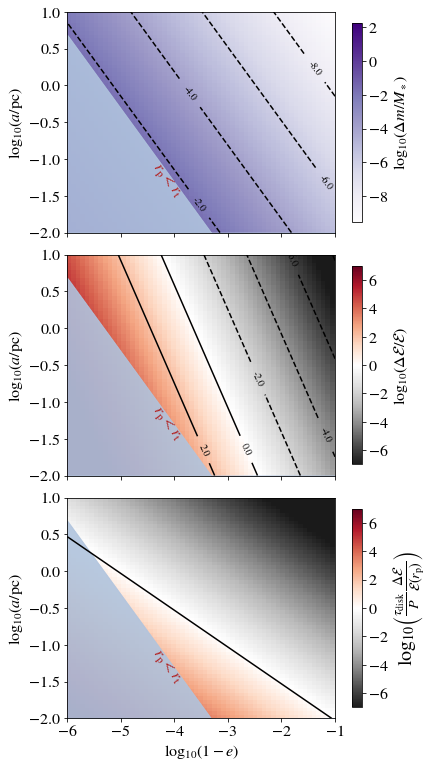

In [121]:


plt.figure(figsize=(6,13))

plt.subplot(311)
# dm_o_M
im=plt.pcolormesh(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(dm_o_ms) ,cmap=plt.cm.Purples,rasterized=True)
cs=plt.contour(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(dm_o_ms),colors='k',
              levels=np.linspace(-10,-2,5))


#plt.xlabel(r"$\log_{10}(1-e)$")
plt.ylabel(r"$\log_{10}(a/{\rm pc})$")
plt.colorbar(im,label=r"$\log_{10}(\Delta m / M_\ast)$",shrink=0.9)
plt.ylim(np.log10(a_list[0]/c.pc),np.log10(a_list[-1]/c.pc))
plt.clabel(cs, inline=1, fontsize=10,fmt='%1.1f')

# tidal radius
plt.fill_between(np.log10(one_minus_ecc_list),np.log10(sma_rt/c.pc),np.log10(a_list[0]/c.pc),
                 alpha=0.9,color='LightSteelBlue')
plt.annotate(r'$r_{\rm p}<r_{\rm t}$',(-4.5,-1.15),rotation=-53,color='FireBrick')
plt.xticks(visible=False)





plt.subplot(312)
# dE_o_E
im=plt.pcolormesh(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(DeltaEoE),cmap=plt.cm.RdGy_r,vmin=-7,vmax=7,rasterized=True )
cs=plt.contour(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(DeltaEoE),colors='k',levels=np.linspace(-8,2,6))

# tidal radius
plt.fill_between(np.log10(one_minus_ecc_list),np.log10(sma_rt/c.pc),np.log10(a_list[0]/c.pc),alpha=0.9,color='LightSteelBlue')
plt.annotate(r'$r_{\rm p}<r_{\rm t}$',(-4.5,-1.15),rotation=-53,color='FireBrick')

#plt.xlabel(r"$\log_{10}(1-e)$")
plt.ylabel(r"$\log_{10}(a/{\rm pc})$")
plt.colorbar(im,label=r"$\log_{10}(\Delta \cal E / \cal E)$",shrink=0.9)
plt.ylim(np.log10(a_list[0]/c.pc),np.log10(a_list[-1]/c.pc))
plt.clabel(cs, inline=1, fontsize=10,fmt='%1.1f')
plt.xticks(visible=False)





plt.subplot(313)
# dE_o_E
im=plt.pcolormesh(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(Norb*DeltaEoEcirc),cmap=plt.cm.RdGy_r,vmin=-7,vmax=7,rasterized=True )
cs=plt.contour(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(Norb*DeltaEoEcirc),colors='k',levels=[0])

# tidal radius
plt.fill_between(np.log10(one_minus_ecc_list),np.log10(sma_rt/c.pc),np.log10(a_list[0]/c.pc),alpha=0.9,color='LightSteelBlue')
plt.annotate(r'$r_{\rm p}<r_{\rm t}$',(-4.5,-1.15),rotation=-53,color='FireBrick')

plt.xlabel(r"$\log_{10}(1-e)$")
plt.ylabel(r"$\log_{10}(a/{\rm pc})$")
#plt.colorbar(im,label=r"$\log_{10}\left(\tau_{\rm disk} \frac{\Delta \cal E}{\cal E} \right)$")
cb=plt.colorbar(im,shrink=0.9)
cb.set_label(r"$\log_{10}\left( \frac{\tau_{\rm disk}}{P} \frac{\Delta {\cal E}}{ {\cal E}(r_{\rm p})}\right)$",fontsize=20)
plt.ylim(np.log10(a_list[0]/c.pc),np.log10(a_list[-1]/c.pc))
#plt.clabel(cs, inline=1, fontsize=10,fmt='%1.1f')


plt.subplots_adjust(hspace=0.1,wspace=0.3)
#plt.savefig("Tidal_LC.pdf",bbox_inches='tight')

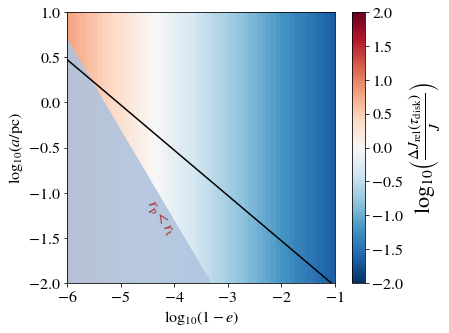

In [21]:
# dm_o_M
im=plt.pcolormesh(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(DeltaJtdisk_oJ) ,
                  cmap=plt.cm.RdBu_r,vmin=-2,vmax=2,rasterized=True)
#cs=plt.contour(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(dm_o_ms),colors='k',
#              levels=np.linspace(-10,-2,5))

cs=plt.contour(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(Norb*DeltaEoEcirc),colors='k',levels=[0])




plt.xlabel(r"$\log_{10}(1-e)$")
plt.ylabel(r"$\log_{10}(a/{\rm pc})$")
cb = plt.colorbar(im)
cb.set_label(r"$\log_{10}\left(\frac{\Delta J_{\rm rel} (\tau_{\rm disk})}{J}\right)$",fontsize=22)
plt.ylim(np.log10(a_list[0]/c.pc),np.log10(a_list[-1]/c.pc))
#plt.clabel(cs, inline=1, fontsize=10,fmt='%1.1f')


# tidal radius
plt.fill_between(np.log10(one_minus_ecc_list),np.log10(sma_rt/c.pc),np.log10(a_list[0]/c.pc),
                 alpha=0.9,color='LightSteelBlue')
plt.annotate(r'$r_{\rm p}<r_{\rm t}$',(-4.6,-1.15),rotation=-57,color='FireBrick')
plt.savefig("DeltaJtb_lc.pdf",bbox_inches='tight')

('Mdot_Edd = ', 0.22182035411211506, '(msun/yr) Mdot_disk =', 0.22182035411211506, '(msun/yr)')
('Mdot_Edd = ', 0.22182035411211506, '(msun/yr) Mdot_disk =', 0.22182035411211506, '(msun/yr)')
('Mdot_Edd = ', 0.22182035411211506, '(msun/yr) Mdot_disk =', 0.22182035411211506, '(msun/yr)')
('Mdot_Edd = ', 0.022182035411211505, '(msun/yr) Mdot_disk =', 0.022182035411211505, '(msun/yr)')
('Mdot_Edd = ', 0.22182035411211506, '(msun/yr) Mdot_disk =', 0.22182035411211506, '(msun/yr)')
('Mdot_Edd = ', 2.2182035411211505, '(msun/yr) Mdot_disk =', 2.2182035411211505, '(msun/yr)')


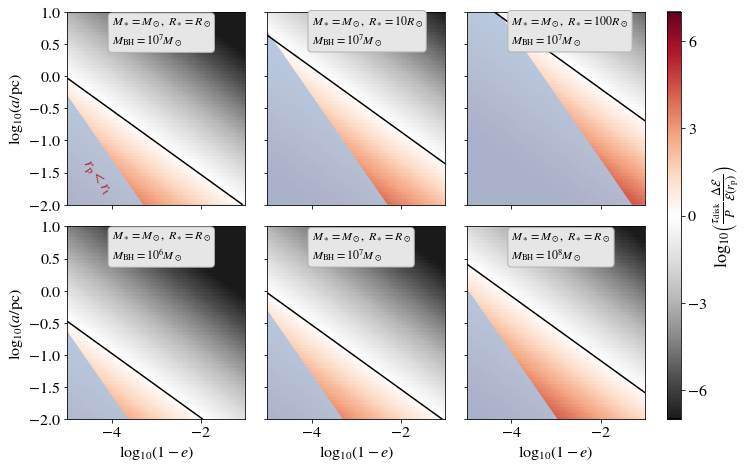

In [22]:
from mpl_toolkits.axes_grid1 import ImageGrid



bbox = dict(boxstyle="round", fc="0.9", ec='0.7')
fs = 12

fig = plt.figure(figsize=(11,7.5))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 3),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 share_all=True,
                cbar_mode='single',
                cbar_location='right',
                cbar_size='4%',
                aspect=False)





#### PANEL 0 ####
ind=0
s=star_disk(Mbh=1.e7*c.msun,
            ms=c.msun,
            rs=1*c.rsun,
            lambda_disk=1,
            alpha_disk =1,
            Q_disk=1,
            gamma=1.5) 

npoints = 60
one_minus_ecc_list = np.logspace(-5,-1,npoints)
a_list = np.logspace(-2,1,npoints)*c.pc
O_M_ECC,SMA = np.meshgrid(one_minus_ecc_list,a_list)
dm_o_ms = (s.d.sigma(SMA*O_M_ECC)*np.pi*s.rs**2 / s.ms)
DeltaEoE = 4* dm_o_ms * O_M_ECC**-1
DeltaEoEcirc = 4* dm_o_ms
tdisk = 1.e6*c.yr
Porb = s.n.P(SMA)
Norb = tdisk/Porb



rt = (s.Mbh/s.ms)**(1./3.)*s.rs
#a(1-e)=rt
#a=rt/(1-e)
sma_rt = rt / one_minus_ecc_list

im=grid[ind].pcolormesh(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(Norb*DeltaEoEcirc),cmap=plt.cm.RdGy_r,vmin=-7,vmax=7,rasterized=True )
cs=grid[ind].contour(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(Norb*DeltaEoEcirc),colors='k',levels=[0])

# tidal radius
grid[ind].fill_between(np.log10(one_minus_ecc_list),np.log10(sma_rt/c.pc),np.log10(a_list[0]/c.pc),alpha=0.9,color='LightSteelBlue')
grid[ind].annotate(r'$r_{\rm p}<r_{\rm t}$',(-4.75,-1.4),rotation=-55,color='FireBrick')

grid[ind].set_xlabel(r"$\log_{10}(1-e)$")
grid[ind].set_ylabel(r"$\log_{10}(a/{\rm pc})$")
cb=grid[ind].cax.colorbar(im)
#cb.set_label_text(r"$\log_{10}\left( \frac{\tau_{\rm disk}}{P_{\rm orb}} \frac{\Delta E}{E_{\rm circ}}\right)$",fontsize=18)
grid[ind].set_ylim(np.log10(a_list[0]/c.pc),np.log10(a_list[-1]/c.pc))
#grid[ind].clabel(cs, inline=1, fontsize=10,fmt='%1.1f')

grid[ind].annotate(r"$M_\ast = M_\odot,\  R_\ast = R_\odot$"+"\n"+r"$M_{\rm BH}=10^7M_\odot$",(-4,0.5),bbox =bbox,fontsize=fs)




#### PANEL 1 ####
ind=1
s=star_disk(Mbh=1.e7*c.msun,
            ms=c.msun,
            rs=10*c.rsun,
            lambda_disk=1,
            alpha_disk =1,
            Q_disk=1,
            gamma=1.5) 

npoints = 60
one_minus_ecc_list = np.logspace(-5,-1,npoints)
a_list = np.logspace(-2,1,npoints)*c.pc
O_M_ECC,SMA = np.meshgrid(one_minus_ecc_list,a_list)
dm_o_ms = (s.d.sigma(SMA*O_M_ECC)*np.pi*s.rs**2 / s.ms)
DeltaEoE = 4* dm_o_ms * O_M_ECC**-1
DeltaEoEcirc = 4* dm_o_ms
tdisk = 1.e6*c.yr
Porb = s.n.P(SMA)
Norb = tdisk/Porb



rt = (s.Mbh/s.ms)**(1./3.)*s.rs
#a(1-e)=rt
#a=rt/(1-e)
sma_rt = rt / one_minus_ecc_list

im=grid[ind].pcolormesh(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(Norb*DeltaEoEcirc),cmap=plt.cm.RdGy_r,vmin=-7,vmax=7,rasterized=True )
cs=grid[ind].contour(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(Norb*DeltaEoEcirc),colors='k',levels=[0])

# tidal radius
grid[ind].fill_between(np.log10(one_minus_ecc_list),np.log10(sma_rt/c.pc),np.log10(a_list[0]/c.pc),alpha=0.9,color='LightSteelBlue')
#grid[ind].annotate(r'$r_{\rm p}<r_{\rm t}$',(-4.,-0.9),rotation=-55,color='FireBrick')

grid[ind].set_xlabel(r"$\log_{10}(1-e)$")
grid[ind].set_ylabel(r"$\log_{10}(a/{\rm pc})$")
cb=grid[ind].cax.colorbar(im)
#cb.set_label_text(r"$\log_{10}\left( \frac{\tau_{\rm disk}}{P_{\rm orb}} \frac{\Delta E}{E_{\rm circ}}\right)$",fontsize=18)
grid[ind].set_ylim(np.log10(a_list[0]/c.pc),np.log10(a_list[-1]/c.pc))
#grid[ind].clabel(cs, inline=1, fontsize=10,fmt='%1.1f')


grid[ind].annotate(r"$M_\ast = M_\odot,\  R_\ast = 10 R_\odot$"+"\n"+r"$M_{\rm BH}=10^7M_\odot$",(-4,0.5),bbox =bbox,fontsize=fs)




#### PANEL 2 ####
ind=2
s=star_disk(Mbh=1.e7*c.msun,
            ms=c.msun,
            rs=100*c.rsun,
            lambda_disk=1,
            alpha_disk =1,
            Q_disk=1,
            gamma=1.5) 

npoints = 60
one_minus_ecc_list = np.logspace(-5,-1,npoints)
a_list = np.logspace(-2,1,npoints)*c.pc
O_M_ECC,SMA = np.meshgrid(one_minus_ecc_list,a_list)
dm_o_ms = (s.d.sigma(SMA*O_M_ECC)*np.pi*s.rs**2 / s.ms)
DeltaEoE = 4* dm_o_ms * O_M_ECC**-1
DeltaEoEcirc = 4* dm_o_ms
tdisk = 1.e6*c.yr
Porb = s.n.P(SMA)
Norb = tdisk/Porb



rt = (s.Mbh/s.ms)**(1./3.)*s.rs
#a(1-e)=rt
#a=rt/(1-e)
sma_rt = rt / one_minus_ecc_list

im=grid[ind].pcolormesh(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(Norb*DeltaEoEcirc),cmap=plt.cm.RdGy_r,vmin=-7,vmax=7,rasterized=True )
cs=grid[ind].contour(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(Norb*DeltaEoEcirc),colors='k',levels=[0])

# tidal radius
grid[ind].fill_between(np.log10(one_minus_ecc_list),np.log10(sma_rt/c.pc),np.log10(a_list[0]/c.pc),alpha=0.9,color='LightSteelBlue')
#grid[ind].annotate(r'$r_{\rm p}<r_{\rm t}$',(-3.5,-0.5),rotation=-55,color='FireBrick')

grid[ind].set_xlabel(r"$\log_{10}(1-e)$")
grid[ind].set_ylabel(r"$\log_{10}(a/{\rm pc})$")
cb=grid[ind].cax.colorbar(im)
#cb.set_label_text(r"$\log_{10}\left( \frac{\tau_{\rm disk}}{P_{\rm orb}} \frac{\Delta E}{E_{\rm circ}}\right)$",fontsize=18)
grid[ind].set_ylim(np.log10(a_list[0]/c.pc),np.log10(a_list[-1]/c.pc))
#grid[ind].clabel(cs, inline=1, fontsize=10,fmt='%1.1f')


grid[ind].annotate(r"$M_\ast = M_\odot,\  R_\ast = 100 R_\odot$"+"\n"+r"$M_{\rm BH}=10^7M_\odot$",(-4,0.5),bbox =bbox,fontsize=fs)




#### PANEL 3 ####
ind=3
s=star_disk(Mbh=1.e6*c.msun,
            ms=c.msun,
            rs=c.rsun,
            lambda_disk=1,
            alpha_disk =1,
            Q_disk=1,
            gamma=1.5) 

npoints = 60
one_minus_ecc_list = np.logspace(-5,-1,npoints)
a_list = np.logspace(-2,1,npoints)*c.pc
O_M_ECC,SMA = np.meshgrid(one_minus_ecc_list,a_list)
dm_o_ms = (s.d.sigma(SMA*O_M_ECC)*np.pi*s.rs**2 / s.ms)
DeltaEoE = 4* dm_o_ms * O_M_ECC**-1
DeltaEoEcirc = 4* dm_o_ms
tdisk = 1.e6*c.yr
Porb = s.n.P(SMA)
Norb = tdisk/Porb



rt = (s.Mbh/s.ms)**(1./3.)*s.rs
#a(1-e)=rt
#a=rt/(1-e)
sma_rt = rt / one_minus_ecc_list

im=grid[ind].pcolormesh(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(Norb*DeltaEoEcirc),cmap=plt.cm.RdGy_r,vmin=-7,vmax=7,rasterized=True )
cs=grid[ind].contour(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(Norb*DeltaEoEcirc),colors='k',levels=[0])

# tidal radius
grid[ind].fill_between(np.log10(one_minus_ecc_list),np.log10(sma_rt/c.pc),np.log10(a_list[0]/c.pc),alpha=0.9,color='LightSteelBlue')
#grid[ind].annotate(r'$r_{\rm p}<r_{\rm t}$',(-5,-1.5),rotation=-55,color='FireBrick')

grid[ind].set_xlabel(r"$\log_{10}(1-e)$")
grid[ind].set_ylabel(r"$\log_{10}(a/{\rm pc})$")
cb=grid[ind].cax.colorbar(im)
#cb.set_label_text(r"$\log_{10}\left( \frac{\tau_{\rm disk}}{P_{\rm orb}} \frac{\Delta E}{E_{\rm circ}}\right)$",fontsize=18)
grid[ind].set_ylim(np.log10(a_list[0]/c.pc),np.log10(a_list[-1]/c.pc))
#grid[ind].clabel(cs, inline=1, fontsize=10,fmt='%1.1f')

grid[ind].annotate(r"$M_\ast = M_\odot,\  R_\ast = R_\odot$"+"\n"+r"$M_{\rm BH}=10^6M_\odot$",(-4,0.5),bbox =bbox,fontsize=fs)





#### PANEL 4 ####
ind=4
s=star_disk(Mbh=1.e7*c.msun,
            ms=c.msun,
            rs=c.rsun,
            lambda_disk=1,
            alpha_disk =1,
            Q_disk=1,
            gamma=1.5) 

npoints = 60
one_minus_ecc_list = np.logspace(-5,-1,npoints)
a_list = np.logspace(-2,1,npoints)*c.pc
O_M_ECC,SMA = np.meshgrid(one_minus_ecc_list,a_list)
dm_o_ms = (s.d.sigma(SMA*O_M_ECC)*np.pi*s.rs**2 / s.ms)
DeltaEoE = 4* dm_o_ms * O_M_ECC**-1
DeltaEoEcirc = 4* dm_o_ms
tdisk = 1.e6*c.yr
Porb = s.n.P(SMA)
Norb = tdisk/Porb



rt = (s.Mbh/s.ms)**(1./3.)*s.rs
#a(1-e)=rt
#a=rt/(1-e)
sma_rt = rt / one_minus_ecc_list

im=grid[ind].pcolormesh(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(Norb*DeltaEoEcirc),cmap=plt.cm.RdGy_r,vmin=-7,vmax=7,rasterized=True )
cs=grid[ind].contour(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(Norb*DeltaEoEcirc),colors='k',levels=[0])

# tidal radius
grid[ind].fill_between(np.log10(one_minus_ecc_list),np.log10(sma_rt/c.pc),np.log10(a_list[0]/c.pc),alpha=0.9,color='LightSteelBlue')
#grid[ind].annotate(r'$r_{\rm p}<r_{\rm t}$',(-4.75,-1.4),rotation=-55,color='FireBrick')

grid[ind].set_xlabel(r"$\log_{10}(1-e)$")
grid[ind].set_ylabel(r"$\log_{10}(a/{\rm pc})$")
cb=grid[ind].cax.colorbar(im)
#cb.set_label_text(r"$\log_{10}\left( \frac{\tau_{\rm disk}}{P_{\rm orb}} \frac{\Delta E}{E_{\rm circ}}\right)$",fontsize=18)
grid[ind].set_ylim(np.log10(a_list[0]/c.pc),np.log10(a_list[-1]/c.pc))
#grid[ind].clabel(cs, inline=1, fontsize=10,fmt='%1.1f')

grid[ind].annotate(r"$M_\ast = M_\odot,\  R_\ast = R_\odot$"+"\n"+r"$M_{\rm BH}=10^7M_\odot$",(-4,0.5),bbox =bbox,fontsize=fs)






#### PANEL 5 ####
ind=5
s=star_disk(Mbh=1.e8*c.msun,
            ms=c.msun,
            rs=c.rsun,
            lambda_disk=1,
            alpha_disk =1,
            Q_disk=1,
            gamma=1.5) 

npoints = 60
one_minus_ecc_list = np.logspace(-5,-1,npoints)
a_list = np.logspace(-2,1,npoints)*c.pc
O_M_ECC,SMA = np.meshgrid(one_minus_ecc_list,a_list)
dm_o_ms = (s.d.sigma(SMA*O_M_ECC)*np.pi*s.rs**2 / s.ms)
DeltaEoE = 4* dm_o_ms * O_M_ECC**-1
DeltaEoEcirc = 4* dm_o_ms
tdisk = 1.e6*c.yr
Porb = s.n.P(SMA)
Norb = tdisk/Porb



rt = (s.Mbh/s.ms)**(1./3.)*s.rs
#a(1-e)=rt
#a=rt/(1-e)
sma_rt = rt / one_minus_ecc_list

im=grid[ind].pcolormesh(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(Norb*DeltaEoEcirc),cmap=plt.cm.RdGy_r,vmin=-7,vmax=7,rasterized=True )
cs=grid[ind].contour(np.log10(O_M_ECC),np.log10(SMA/c.pc),np.log10(Norb*DeltaEoEcirc),colors='k',levels=[0])

# tidal radius
grid[ind].fill_between(np.log10(one_minus_ecc_list),np.log10(sma_rt/c.pc),np.log10(a_list[0]/c.pc),alpha=0.9,color='LightSteelBlue')
#grid[ind].annotate(r'$r_{\rm p}<r_{\rm t}$',(-4.5,-1.15),rotation=-55,color='FireBrick')

grid[ind].set_xlabel(r"$\log_{10}(1-e)$")
grid[ind].set_ylabel(r"$\log_{10}(a/{\rm pc})$")
cb=grid[ind].cax.colorbar(im)
cb.set_label_text(r"$\log_{10}\left( \frac{\tau_{\rm disk}}{P} \frac{\Delta {\cal E}}{{\cal E} (r_{\rm p})}\right)$",fontsize=18)
grid[ind].set_ylim(np.log10(a_list[0]/c.pc),np.log10(a_list[-1]/c.pc))
#grid[ind].clabel(cs, inline=1, fontsize=10,fmt='%1.1f')



grid[ind].annotate(r"$M_\ast = M_\odot,\  R_\ast = R_\odot$"+"\n"+r"$M_{\rm BH}=10^8M_\odot$",(-4,0.5),bbox =bbox,fontsize=fs)


plt.savefig('Tidal_LC_composite.pdf',bbox_inches='tight')

# TDE Flux

In [34]:
from scipy.integrate import quad
from scipy.optimize import bisect

def ome_root_disk(one_minus_ecc,sma,Rs,Ms,tdisk=1.e6*c.yr):    
    Norb=tdisk/s.n.P(sma)
    dm_o_ms = (s.d.sigma(sma*one_minus_ecc)*np.pi*Rs**2 / Ms)
    DeltaEoEcirc = 4* dm_o_ms
    return Norb*DeltaEoEcirc - 1.0

def one_minus_ecc_lc_disk(sma,Rs,Ms):
    return bisect(ome_root_disk,1.e-30,1,args=(sma,Rs,Ms)) 

def r_lc_disk(sma,Rs,Ms):
    return sma*one_minus_ecc_lc_disk(sma,Rs,Ms)
r_lc_disk = np.vectorize(r_lc_disk)


def fR_frac(R,R0):
    tol=1.e-300
    return np.where(R0>tol,np.log(R/R0)/(np.log(1/R0)-1.0+R0),1.0)

def flux_lc_disk(E,rlc_tidal):
    """flux into the TDE lc in the presence of a disk"""
    # disk loss cone radius, and R0
    rlcd = r_lc_disk(s.n.a(E),s.rs,s.ms)
    Rlc_disk = s.n.Rlc(E,rlcd)
    R0_d = s.n.R0(E,rlcd)
    R0_t = s.n.R0(E,rlc_tidal)
    R0 = max(R0_d,R0_t)
    Rlc_tidal = s.n.Rlc(E,rlc_tidal)
    
    if (R0_d>=Rlc_tidal):
        return 0.0
    else:
        # integrate over angular momenta
        fE = quad(fR_frac,R0,Rlc_tidal,args=(R0))[0] * s.n.fE(E) * (1-R0) # last term, depletion by disk
        return 4.*np.pi**2 * s.n.Jc(s.n.a(E))**2 * fE 

flux_lc_disk = np.vectorize(flux_lc_disk)

def flux_lc_tidal(E,rlc_tidal):
    """Flux into a normal lc, eg the tidal lc"""
    # TDE loss cone radius, and R0
    R0 = s.n.R0(E,rlc_tidal)
    Rlc_tidal = s.n.Rlc(E,rlc_tidal)
    
    # integrate over angular momenta
    fE = s.n.fE(E)*quad(fR_frac,R0,Rlc_tidal,args=(R0))[0]
    return 4.*np.pi**2 * s.n.Jc(s.n.a(E))**2 * fE 
flux_lc_tidal = np.vectorize(flux_lc_tidal)



def flux_lc_diskcap(E,rlc_tidal):
    """flux into the disk capture LC in the presence of a disk"""
    # disk loss cone radius, and R0
    rlcd = r_lc_disk(s.n.a(E),s.rs,s.ms)
    Rlc_disk = s.n.Rlc(E,rlcd)
    R0_d = s.n.R0(E,rlcd)
    R0_t = s.n.R0(E,rt)
    R0 = max(R0_d,R0_t)
    Rlc_tidal = s.n.Rlc(E,rlc_tidal)
    Rmin = max(R0,Rlc_tidal)
    
    if (Rlc_tidal >= Rlc_disk):
        return 0.0
    else:
        # integrate over angular momenta
        fE = quad(fR_frac,Rmin,Rlc_disk,args=(R0))[0] * s.n.fE(E) * (1-R0) # last term, depletion by disk of overall normalization
        return 4.*np.pi**2 * s.n.Jc(s.n.a(E))**2 * fE 

flux_lc_diskcap = np.vectorize(flux_lc_diskcap)


('Mdot_Edd = ', 0.22182035411211506, '(msun/yr) Mdot_disk =', 0.22182035411211506, '(msun/yr)')


/Users/morganmacleod/CODE/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in double_scalars
/Users/morganmacleod/CODE/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/morganmacleod/CODE/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


('Mbh =', 10000000.0, 'msun')
('sigma =', 91.1803703800426, 'km/s')
('total rate =', 0.00015601213527869978, '   log10(rate) =', -3.8068416190840133)
('total rate disk =', 0.00014681966612224934, '   log10(rate) =', -3.833215767878173)


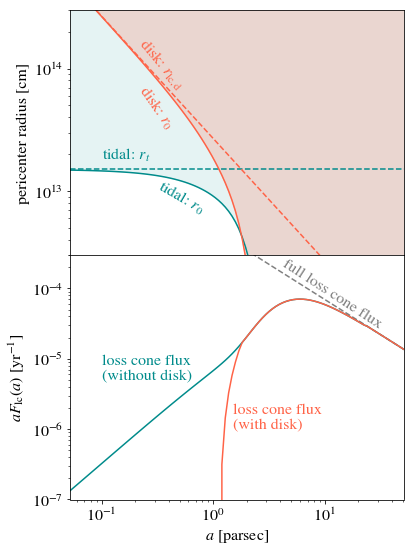

In [132]:
s=star_disk(Mbh=1.e7*c.msun,
            ms=c.msun,
            rs=1*c.rsun,
            lambda_disk=1,
            alpha_disk =1,
            Q_disk=1,
            gamma=1.5) 


tidal_color = 'DarkCyan'
disk_color = 'Tomato'

rt = 1*(s.Mbh/s.ms)**(1./3.)*s.rs  # specify the tidal radius

alist = np.logspace(np.log10(s.n.r_h/s.n.c.pc)-2,np.log10(s.n.r_h/s.n.c.pc)+1,100)*s.n.c.pc


plt.figure(figsize=(6,9))

plt.subplot(211)
# tidal 
plt.axhline(rt,color=tidal_color,ls='--',label='rt')
plt.plot(alist/c.pc, s.n.R0(s.n.E(alist),rt)*alist/2,color=tidal_color,label='rp0_tidal')
plt.fill_between(alist/c.pc, s.n.R0(s.n.E(alist),rt)*alist/2 ,1.e15,color=tidal_color,alpha=0.1)


# disk
rlcd = r_lc_disk(alist,s.rs,s.ms)
plt.plot(alist/c.pc,rlcd ,'--',color=disk_color,label='r_lc_disk')
plt.plot(alist/c.pc, s.n.R0(s.n.E(alist),rlcd)*alist/2 ,'-',color=disk_color,label='rp0_disk')
plt.fill_between(alist/c.pc, s.n.R0(s.n.E(alist),rlcd)*alist/2 ,1.e15,color=disk_color,alpha=0.2)


plt.annotate(r'tidal: $r_t$',(0.1,1.2*rt),color=tidal_color)
plt.annotate(r'tidal: $r_{0}$',(0.3,rt/1.5),rotation=-30,color=tidal_color)

plt.annotate(r'disk: $r_{\rm lc,d}$',(0.2,1.5e14),rotation=-50,color=disk_color)
plt.annotate(r'disk: $r_{0}$',(0.2,4*rt),rotation=-55,color=disk_color)



plt.loglog()
#plt.xlabel(r'$ a$ [parsec]')
plt.ylabel(r'pericenter radius [cm]')
#plt.legend()
plt.ylim(3.e12,3.e14)
plt.xlim(alist[0]/c.pc,alist[-1]/c.pc)
#plt.grid()
plt.xticks(visible=False)





plt.subplot(212)
plt.plot(alist/c.pc,s.n.flux_flc(s.n.E(alist),rt)*s.n.E(alist)*s.n.c.yr,color='grey',ls="--")
#plt.plot(alist/c.pc,s.n.flux_lc(s.n.E(alist),rt)*s.n.E(alist)*s.n.c.yr)

# with the disk
plt.plot(alist/c.pc,flux_lc_tidal(s.n.E(alist),rt)*s.n.E(alist)*s.n.c.yr,color=tidal_color)
plt.plot(alist/c.pc,flux_lc_disk(s.n.E(alist),rt)*s.n.E(alist)*s.n.c.yr,color=disk_color)


plt.annotate(r'full loss cone flux',(4,2.e-4),rotation=-33,color='grey')
plt.annotate('loss cone flux\n(without disk)',(0.1,5.e-6),color=tidal_color)
plt.annotate('loss cone flux\n(with disk)',(1.5,1.e-6),color=disk_color)


plt.loglog()
plt.xlabel(r'$ a$ [parsec]')
plt.ylabel(r"$a F_{\rm lc}( a)$ [yr$^{-1}$]")
#plt.grid()
plt.ylim(1.e-7,3.e-4)
plt.xlim(alist[0]/c.pc,alist[-1]/c.pc)


plt.subplots_adjust(hspace=0)
#plt.savefig("tidal_disruption_flux.pdf",bbox_inches='tight')



rate = quad(flux_lc_tidal,s.n.E(alist[-1]),s.n.E(alist[0]),args=(rt))[0]*s.n.c.yr
rate_disk = quad(flux_lc_disk,s.n.E(alist[-1]),s.n.E(alist[0]),args=(rt))[0]*s.n.c.yr


print ("======================================================" )
print ("Mbh =",s.n.Mbh/s.n.c.msun,"msun" )
print ("sigma =",s.n.sigma_h/1.e5,"km/s" )
print ("total rate =",rate, "   log10(rate) =",np.log10(rate) )
print ("total rate disk =",rate_disk, "   log10(rate) =",np.log10(rate_disk) )
print ("======================================================" )

# TDE rate vs Disk

In [59]:
s=star_disk(Mbh=1.e7*c.msun,
            ms=c.msun,
            rs=1*c.rsun,
            lambda_disk=0.001,
            alpha_disk =0.001,
            Q_disk=1000,
            gamma=1.5) 


tidal_color = 'DarkCyan'
disk_color = 'Tomato'

rt = 1*(s.Mbh/s.ms)**(1./3.)*s.rs  # specify the tidal radius

alist = np.logspace(np.log10(s.n.r_h/s.n.c.pc)-2,np.log10(s.n.r_h/s.n.c.pc)+1,100)*s.n.c.pc


plt.figure(figsize=(6,9))

# disk rlc
rlcd = r_lc_disk(alist,s.rs,s.ms)

rate = quad(flux_lc_tidal,s.n.E(alist[-1]),s.n.E(alist[0]),args=(rt))[0]*s.n.c.yr
rate_disk = quad(flux_lc_disk,s.n.E(alist[-1]),s.n.E(alist[0]),args=(rt))[0]*s.n.c.yr
cap_disk = quad(flux_lc_diskcap,s.n.E(alist[-1]),s.n.E(alist[0]),args=(rt))[0]*s.n.c.yr

print ("======================================================" )
print ("Mbh =",s.n.Mbh/s.n.c.msun,"msun" )
print ("sigma =",s.n.sigma_h/1.e5,"km/s" )
print ("TDE rate =",rate, "   log10(rate) =",np.log10(rate) )
print ("TDE rate disk =",rate_disk, "   log10(rate) =",np.log10(rate_disk) )
print ("cap rate disk =",cap_disk, "   log10(rate) =",np.log10(cap_disk) )
print ("======================================================" )

('Mdot_Edd = ', 0.22182035411211506, '(msun/yr) Mdot_disk =', 0.00022182035411211508, '(msun/yr)')


/Users/morganmacleod/CODE/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/morganmacleod/CODE/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


('Mbh =', 10000000.0, 'msun')
('sigma =', 91.1803703800426, 'km/s')
('TDE rate =', 0.00015601213527869978, '   log10(rate) =', -3.8068416190840133)
('TDE rate disk =', 0.0001559252868130831, '   log10(rate) =', -3.807083448423377)
('cap rate disk =', 8.926776068885367e-08, '   log10(rate) =', -7.049305359509459)


<Figure size 432x648 with 0 Axes>

In [133]:
lambda_list = np.logspace(-3,0,7)
res_list = []

for i,lam in enumerate(lambda_list):
    s=star_disk(Mbh=1.e7*c.msun,
            ms=c.msun,
            rs=1*c.rsun,
            lambda_disk=lam,
            alpha_disk =1.e-3,
            Q_disk=1./lam,
            gamma=1.5) 
    
    rt = 1*(s.Mbh/s.ms)**(1./3.)*s.rs  # specify the tidal radius

    alist = np.logspace(np.log10(s.n.r_h/s.n.c.pc)-2,np.log10(s.n.r_h/s.n.c.pc)+1,100)*s.n.c.pc

    # disk rlc
    rlcd = r_lc_disk(alist,s.rs,s.ms)

    rate = quad(flux_lc_tidal,s.n.E(alist[-1]),s.n.E(alist[0]),args=(rt))[0]*s.n.c.yr
    rate_disk = quad(flux_lc_disk,s.n.E(alist[-1]),s.n.E(alist[0]),args=(rt))[0]*s.n.c.yr
    cap_disk = quad(flux_lc_diskcap,s.n.E(alist[-1]),s.n.E(alist[0]),args=(rt))[0]*s.n.c.yr

    res_list.append([lam,lam,1./lam,np.log10(rate),np.log10(rate_disk),np.log10(cap_disk)])

rate_table = Table(np.array(res_list),names=['lambda','alpha','Q','logRTDE','logRTDE_disk','logRcap'])

('Mdot_Edd = ', 0.22182035411211506, '(msun/yr) Mdot_disk =', 0.00022182035411211508, '(msun/yr)')


/Users/morganmacleod/CODE/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/Users/morganmacleod/CODE/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


('Mdot_Edd = ', 0.22182035411211506, '(msun/yr) Mdot_disk =', 0.0007014575503793806, '(msun/yr)')
('Mdot_Edd = ', 0.22182035411211506, '(msun/yr) Mdot_disk =', 0.0022182035411211507, '(msun/yr)')
('Mdot_Edd = ', 0.22182035411211506, '(msun/yr) Mdot_disk =', 0.007014575503793805, '(msun/yr)')
('Mdot_Edd = ', 0.22182035411211506, '(msun/yr) Mdot_disk =', 0.022182035411211505, '(msun/yr)')
('Mdot_Edd = ', 0.22182035411211506, '(msun/yr) Mdot_disk =', 0.07014575503793806, '(msun/yr)')
('Mdot_Edd = ', 0.22182035411211506, '(msun/yr) Mdot_disk =', 0.22182035411211506, '(msun/yr)')


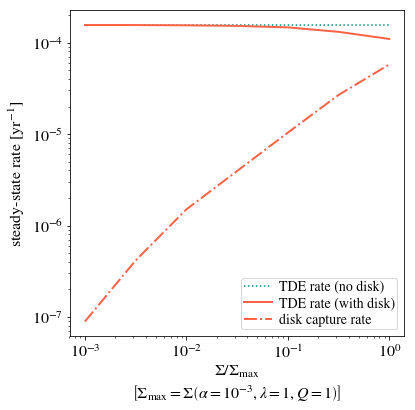

In [160]:
plt.figure(figsize=(6,6))
plt.plot(rate_table['lambda'],10**rate_table['logRTDE'],':',label='TDE rate (no disk)',color=tidal_color)
plt.plot(rate_table['lambda'],10**rate_table['logRTDE_disk'],'-',lw=2,label='TDE rate (with disk)',color=disk_color)
plt.plot(rate_table['lambda'],10**rate_table['logRcap'],'-.',lw=2,label='disk capture rate',color=disk_color)


plt.xlabel(r'$\Sigma / \Sigma_{\rm max}$'+ '\n' +r'$\left[\Sigma_{\rm max} = \Sigma\left(\alpha=10^{-3},\lambda=1,Q=1 \right)\right]$')
plt.ylabel('steady-state rate [yr$^{-1}$]')

#plt.annotate(r"$\Sigma_{\rm max} = \Sigma\left(\alpha=10^{-3},\lambda=1,Q=1 \right)$",(2.e-3,0.4))

plt.legend(loc=0,frameon=True)

plt.loglog()
plt.savefig('TDE_rate.pdf',bbox_inches='tight')